In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
import numpy as np
import os

In [2]:
import pandas as pd

# Reading Dataset as pandas frame 
dataset_path ='data/ansur_result.csv'
column_names = column_names = ['gender','butt_height','buttock-knee_length','buttock-popliteal_length',
                               'crotch_height','knee_height_midpatella','knee_height_sitting', 
                               'lateral-femoral_epicondyle_height', 'popliteal_height',
                               'stature', 'trochanterion_height', 'wrist_height' ]


raw_dataset = pd.read_csv(dataset_path, names=column_names)

dataset = raw_dataset.copy()
dataset.tail()

,gender,butt_height,buttock-knee_length,buttock-popliteal_length,crotch_height,knee_height_midpatella,knee_height_sitting,lateral-femoral_epicondyle_height,popliteal_height,stature,trochanterion_height,wrist_height
3978,m,808,574,456,755,449,507,452,385,1674,836,822
3979,m,943,644,531,894,530,586,533,477,1822,970,915
3980,m,831,600,486,798,470,530,481,410,1708,867,824
3981,m,892,626,515,846,527,585,530,450,1745,922,818
3982,m,808,572,468,793,459,508,463,400,1630,854,777


## Pre-Processing 

In [3]:
x = dataset['knee_height_midpatella']
y = dataset['stature']

x_train = []
y_pred = []


# Fitering Outliers and saving data in arrays
for index, value in enumerate(x):
    if (value != 'knee_height_midpatella') and float(value) > 375 and float(value) < 600 :
        x_train.append(float(value))
        y_pred.append(float(y[index]))
    

# Splitting train data and slicing except last 1500 values for validation      
x_train_float = np.array(x_train[1:len(x_train)-1500])
y_train_float = np.array(y_pred[1:len(y_pred)-1500])


x1 = x_train_float
y1 = y_train_float

# Slicing last 1500 samples to evaluate on them later
x_test_float =  np.array(x_train[-1500:])
y_test_float =  np.array(y_pred[-1500:])

print((len(x_train_float), len(x_test_float)))



(3878, 1500)


592.0 1955.0


Text(0.5, 0, 'x')

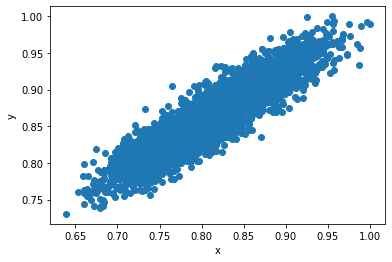

In [4]:
# Normalizing values to be in range (0 - 1) 
x_max = np.amax(x_train_float)
y_max = np.amax(y_train_float)
x_train_float = x_train_float / x_max
y_train_float = y_train_float / y_max

print(x_max, y_max)

plt.plot(x_train_float, y_train_float, 'o')
plt.ylabel("y")
plt.xlabel("x")

## Network

torch.Size([3878]) torch.Size([3878])
epoch: 2, loss = 0.00123
epoch: 4, loss = 0.00105


Text(0, 0.5, 'Loss')

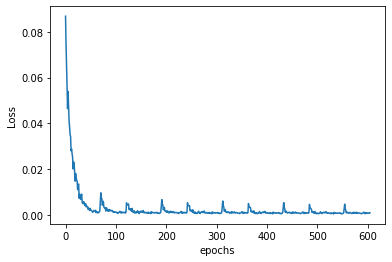

In [5]:
# Converting numpy arrays to pytorch tensors for input

X = torch.from_numpy(np.array(x_train_float, dtype='float32'))
Y = torch.from_numpy(np.array(y_train_float, dtype='float32'))
print(Y.shape, X.shape)

# Reshaping to a list of size (total samples, input SIZE) for input
x = X.view((X.shape[0], 1))
y = Y.view((Y.shape[0], 1))


# defining NN model 
class MyModelA(nn.Module):
    def __init__(self):
        super(MyModelA, self).__init__()
        self.fc1 = nn.Linear(1, 4)
        self.fc2 = nn.Linear(4, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    
    
# creatig a model
model = MyModelA()

# Loss and optimizer
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)  

# Batch Size 
Batch_size = 32
Datset_size= len(X)


iteration = Datset_size // Batch_size

# 3) Training loop
num_epochs = 5
losses = []
for epoch in range(num_epochs):
    # Forward pass and loss

    for i in range(iteration):
        x_batch = x[i*Batch_size:i*Batch_size+ Batch_size]
        y_batch = y[i*Batch_size:i*Batch_size+ Batch_size]
        y_predicted = model(x_batch)
        loss = criterion(y_predicted, y_batch)
        losses.append(loss)

        # Backward pass and update
        loss.backward()
        optimizer.step()
        # zero grad before new step
        optimizer.zero_grad()
        #print('iteration_{}_loss_ {}'.format(i, loss))

    if (epoch+1) % 2 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.5f}')

plt.plot(range(num_epochs*iteration), losses)
plt.xlabel("epochs")
plt.ylabel("Loss")
        
# Plot
#predicted = model(X).detach().numpy()


## Evaluation


In [6]:
# Evaluating using Mean Absolute Error
# scaling test data also between 0-1 to generate result (as the model was also trained with data scaled in range 0-1)
x_test = torch.from_numpy(np.array(x_test_float/x_max, dtype='float32'))
output = model.forward(x_test.view(x_test.shape[0],1))


# Up-scaling output to real size
output *= y_max

# Calculating loss in each test sample and accumlating over all the test set.
total_loss = 0
for index, sample in enumerate(output):
    loss = abs(sample - y_test_float[index])
    #print(loss, sample, y_test_float[index])
    
    total_loss += loss/10

mean_absolute_error = total_loss / len(output)
print(mean_absolute_error)


tensor([4.5752], grad_fn=<DivBackward0>)


In [8]:
# Evaluating using Mean Squared Error
# scaling test data also between 0-1 to generate result (as the model was also trained with data scaled in range 0-1)

x_test = torch.from_numpy(np.array(x_test_float/x_max, dtype='float32'))
# Passing data through trained model
output = model.forward(x_test)

# Upscaling the output to real size
output *= y_max


# Accumulating loss over all the test samples
total_loss = 0
for index, sample in enumerate(output):
    loss = torch.square(sample - y_test_float[index]) 
    #print(loss, sample, y_test_float[index])
    
    total_loss += loss
mean_absolute_error = total_loss / len(output)
print(torchch.sqrt(mean_absolute_error))

RuntimeError: size mismatch, m1: [1 x 1500], m2: [1 x 4] at C:\cb\pytorch_1000000000000\work\aten\src\TH/generic/THTensorMath.cpp:41

### Save Model

In [ ]:
# Saving Trained Model

dirName = 'Trained_models/'
PATH = 'Trained_models/lower_leg_{}'.format(mean_absolute_error.item())

if not os.path.exists(dirName):
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ")
else:    
    print("Directory " , dirName ,  " already exists")
        
#torch.save(model.state_dict(), PATH)
#the_model = torch.load(PATH)

## Average Loss with Pre-calculated weight

In [ ]:
# Parameters from paper to reconstruct height
C1 = 0.289
C2 = 59.745



# Calculating Loss using the formula and accumlating loss over all test samples for comparison with NN results
total_loss = 0

for index, femur in enumerate(x_test_float):
    
    height = (C1 * femur *10) + C2 
    total_loss += abs(height- y_test_float[index])/10
    #print(abs(height- y1[index]/10))
    #print(knee_height, height, y1[index]/10)
    
print(total_loss/len(x_test_float))
       